# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

$\frac{\partial L}{\partial w} = \frac{1}{n}\left[2\sum_j (\langle\,x_j,w\rangle - y_j)x_{j}\right] + \frac{2}{C}w_{old}$

$w_{new} = w_{old} - \alpha \frac{\partial L}{\partial w}$ 

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

$\small
\frac{\partial L}{\partial w}  = $

$\frac{\partial}{\partial w} \,\frac{-1}{n}\sum_{i=1}^n 
\left[ y^{(i)}\log\left(\sigma\left(w^\top x^{(i)}\right)\right) +
(1 -y^{(i)})\log\left(1-\sigma\left(w^\top x^{(i)}\right)\right)\right] \small=$

$\,\frac{-1}{n}\,\sum_{i=1}^n 
\left[ 
y^{(i)}\frac{\partial}{\partial w}\log\left(\sigma\left(w^\top x^{(i)}\right)\right) +
(1 -y^{(i)})\frac{\partial}{\partial w}\log\left(1-\sigma\left(w^\top x^{(i)}\right)\right)
\right] \Tiny=$

$\,\frac{-1}{n}\,\sum_{i=1}^n 
\left[ 
y^{(i)}\frac{\frac{\partial}{\partial w}\sigma\left(w^\top x^{(i)}\right)}{\sigma\left(w^\top x^{(i)}\right)} +
(1 -y^{(i)})\frac{\frac{\partial}{\partial w}\left(1-\sigma\left(w^\top x^{(i)}\right)\right)}{1-\sigma\left(w^\top x^{(i)}\right)}
\right] \Tiny= $

$\frac{-1}{n}\,\sum_{i=1}^n 
\left[ y^{(i)}\,
\frac{\sigma\left(w^\top x^{(i)}\right)\left(1-\sigma\left(w^\top x^{(i)}\right)\right)\frac{\partial}{\partial w}\left(w^\top x^{(i)}\right)}{\sigma\left(w^\top x^{(i)}\right)} -
(1 -y^{(i)})\,\frac{\sigma\left(w^\top x^{(i)}\right)\left(1-\sigma\left(w^\top x^{(i)}\right)\right)\frac{\partial}{\partial w}\left(w^\top x^{(i)}\right)}{1-\sigma\left(w^\top x^{(i)}\right)}
\right] \small=$

$\,\frac{-1}{n}\,\sum_{i=1}^n \left[y^{i}-y^{i}\sigma\left(w^\top x^{(i)}\right)-
\sigma\left(w^\top x^{(i)}\right)+y^{(i)}\sigma\left(w^\top x^{(i)}\right)
\right]\,x^{(i)} \small= $

$\,\frac{-1}{n}\,\sum_{i=1}^n \left[y^{(i)}-\sigma\left(w^\top x^{(i)}\right)\right]\,x^{(i)} \small=$

$\frac{1}{n}\sum_{i=1}^n\left[\sigma\left(w^\top x^{(i)}\right)-y^{(i)}\right]\,x^{(i)}
$

$\Tiny\begin{align}\frac{d}{dx}\sigma(x)&=\frac{d}{dx}\left(\frac{1}{1+e^{-x}}\right)\\
&=\frac{-(1+e^{-x})'}{(1+e^{-x})^2}\\[2ex]
&=\frac{e^{-x}}{(1+e^{-x})^2}\\[2ex]
&=\left(\frac{1}{1+e^{-x}}\right)\left(\frac{e^{-x}}{1+e^{-x}}\right)\\[2ex]
&=\left(\frac{1}{1+e^{-x}}\right)\,\left(\frac{1+e^{-x}}{1+e^{-x}}-\frac{1}{1+e^{-x}}\right)\\[2ex]
&=\sigma(x)\,\left(\frac{1+e^{-x}}{1+e^{-x}}-\sigma(x)\right)\\[2ex]
&=\sigma(x)\,(1-\sigma(x))
\end{align}$

$\frac{\partial L}{\partial w}  = \frac{1}{n}\sum_{i=1}^n\left[\sigma\left(w^\top x^{(i)}\right)-y^{(i)}\right]\,x^{(i)} + \frac{2}{C}w_{old}$


$w_{new} = w_{old} - \alpha \frac{\partial L}{\partial w}$ 


Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***
1.
$\nabla Q_w = 2X^TXw-2X^Ty$

$
\frac{\partial Aw}{\partial w_i \partial w_j} = a_{ij}
$. Для любой матрицы $A$.

Следовательно, матрица Гессе равна $2X^TX$.

Теорема из линейной алгебры: матрица положительно определена тогда и только тогда, когда может быть представлена в виде $B^TB$.

А так как матрица вторых производных положительно определена, то это, действительно, точка минимума.

2.

$Q(w) = \frac{1}{N}(Xw-y)^T(Xw-y)+\frac{1}{C}\sum w^2_i$

$\nabla Q_w = \partial_w(w^TX^TXw-w^TX^Ty-y^TXw+y^Ty+\frac{1}{C}\sum w^2_i) = 2X^TXw-2X^Ty+\frac{2}{C}Ew = 0$

$w = (X^TX+\frac{1}{C}E)^{-1}X^TY$ 
 


Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

$E(L | x_i) = - p(y_i = 1 | x_i)\log a  - (1 -  p(y_i = 1 | x_i)) \log( 1 - a)$ 

Мы видим, что $\frac{\delta E(L|x_i)}{\delta a} = \frac{1- p(y_i = 1 | x_i)}{1-a} - \frac{p(y_i = 1 | x_i)}{a}$ 

Следовательно, $E(L|x_i)$ может достигать локального экстремума только в точке $\frac{1- p(y_i = 1 | x_i)}{1-a} - \frac{ p(y_i = 1 | x_i)}{a} = 0$ 

$$\frac{1- p(y_i = 1 | x_i)}{1-a} = \frac{ p(y_i = 1 | x_i)}{a}$$
$$(1- p(y_i = 1 | x_i))a = (1 - a) p(y_i = 1 | x_i)$$
$$ a = p(y_i = 1 | x_i)$$

Tак как $\frac{\delta E(L|x_i)}{\delta a} = \frac{1- p(y_i = 1 | x_i)}{1-a} - \frac{ p(y_i = 1 | x_i)}{a}$ неубывает как функция от $a$ (вторая производныа больше $0$), то $a = p(y_i = 1 | x_i) -$ точка минимума. 

Таким образом $a(x_i) = p(y_i = 1 | x_i)$ действительно оптимизирует $E(L| x_i)$

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***
По идее не нужно, так как будет плохо работать на выборке, таргет которой расположен далеко от $0$

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [3]:
import random

def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    N = X.shape[0]
    random_sort = np.array(range(N))
    if shuffle: np.random.shuffle(random_sort)
    
    num_of_batchs = N//batch_size
    
    for i in range(num_of_batchs):
        X_batch = X[random_sort[i*batch_size:(i+1)*batch_size]]
        y_batch = y[random_sort[i*batch_size:(i+1)*batch_size]]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1)

In [4]:
#%%pycodestyle
def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value_x = 1./(1 + np.exp(-x))
    return sigm_value_x

from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', batch_size = 1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size 
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            pred = np.dot(X_batch, self.weights)
            loss = ((pred - y_batch)**2).mean()  + 1/self.C*(self.weights**2).sum()
        elif self.model_type == 'log_reg':
            pred = sigmoid(np.dot(X_batch, self.weights))
            loss = -(y_batch * np.log(pred) + (1- y_batch)*np.log(1-pred)).mean() + 1/self.C*(self.weights**2).sum()
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        loss_grad = np.zeros(X_batch.shape[1])
        for i in range(X_batch.shape[0]):
            if self.model_type == 'lin_reg':
                loss_grad += 2./X_batch.shape[0]*(np.dot(X_batch[i],self.weights)-y_batch[i])*X_batch[i]
            elif self.model_type == 'log_reg':
                loss_grad += 1./X_batch.shape[0]*(sigmoid(np.dot(X_batch[i],self.weights))-y_batch[i])*X_batch[i]    
            loss_grad += 2./self.C*self.weights
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - self.alpha * new_grad
        return
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        X = np.hstack((np.ones(X.shape[0])[:, np.newaxis],X))
        # Нужно инициализровать случайно веса
        self.weights = np.random.rand(X.shape[1])
        #self.weights = np.ones(X.shape[1], dtype=np.float64)
        for n in range(0, self.max_epoch):
            #print(n,'Epoch')
            new_epoch_generator = self.batch_generator(X,y, batch_size = self.batch_size, shuffle = True)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.hstack((np.ones(X.shape[0])[:, np.newaxis],X))
        if  self.model_type == 'lin_reg':
            y_hat = np.dot(X, self.weights)    
        elif self.model_type == 'log_reg':
            y_hat = sigmoid(np.dot(X, self.weights))
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [11]:
import matplotlib.pyplot as plt

def plot_decision_boundary(clf):
    w = clf.weights
    x = np.linspace(-10., 10.)
    y = np.linspace(-10., 10.)[:, None]
    plt.contour(x, y.ravel(), w[1]*x + w[2]*y + w[0], [0.3])


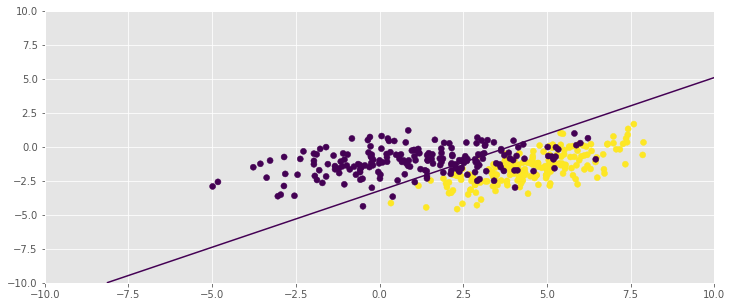

In [12]:
from matplotlib.pyplot import plot
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
my_batch_generator = batch_generator
regr = MySGDClassifier(my_batch_generator, model_type='lin_reg')
regr.fit(X,y)
plot_decision_boundary(regr)
plt.scatter(X[:,0], X[:,1], c=y)

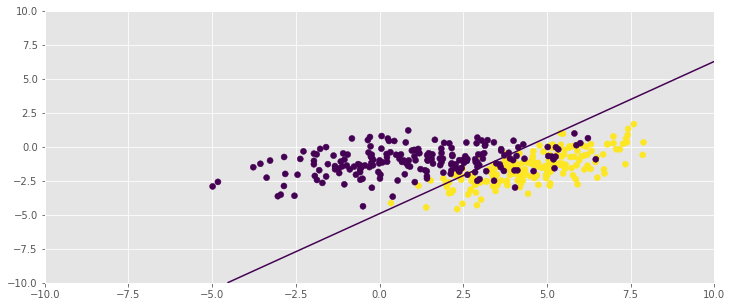

In [13]:
regr = MySGDClassifier(my_batch_generator, model_type='log_reg', C = 1000)
regr.fit(X,y)
plot_decision_boundary(regr)
plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [8]:
from sklearn.datasets import make_classification

In [9]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

убрала random в алгоритме для этого задания, чтобы начинались из одной точи и было удобно сравнивать

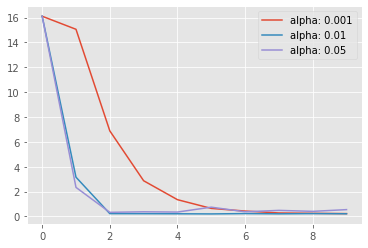

In [134]:
my_batch_generator = batch_generator

for alpha in [0.001, 0.01, 0.05]:
    my_clf = MySGDClassifier(my_batch_generator, alpha=alpha, max_epoch=1, model_type='lin_reg')
    my_clf.fit(X, y)
    errors = my_clf.errors_log['loss'][0:1000]
    errors_new = [errors[0]]
    tmp = []
    for i in errors:
        tmp.append(i)
        if len(tmp)>100:
            errors_new.append(sum(tmp)/len(tmp))
            tmp = []
    plot(range(len(errors_new)), errors_new , label='alpha: {}'.format(alpha))
plt.legend()

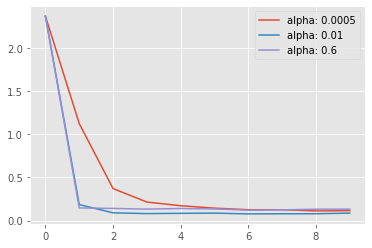

In [131]:
from matplotlib.pyplot import plot

my_batch_generator = batch_generator
for alpha in [0.0005, 0.01, 0.6]:
    my_clf = MySGDClassifier(my_batch_generator,  alpha=alpha, max_epoch=1, model_type='log_reg', C =1000)
    my_clf.fit(X, y)
    errors = my_clf.errors_log['loss'][0:50000]
    errors_new = [errors[0]]
    tmp = []
    for i in errors:
        tmp.append(i)
        if len(tmp)>5000:
            errors_new.append(sum(tmp)/len(tmp))
            tmp = []
    plot(range(len(errors_new)), errors_new , label='alpha: {}'.format(alpha))
plt.legend()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Чем круче график, тем лучше сходимость

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in square
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square


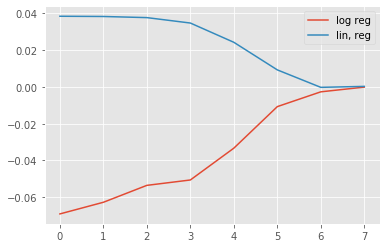

In [135]:
## Your Code Here
weights_lin = []
weights_log = []
for C in np.logspace(3,-3,10):
    my_clf = MySGDClassifier(my_batch_generator, C = C,  alpha= 0.01, max_epoch=10, model_type='lin_reg')
    my_clf.fit(X, y) 
    weights_lin.append(my_clf.weights.mean())
    my_clf = MySGDClassifier(my_batch_generator, C = C,  alpha= 0.01, max_epoch=10, model_type='log_reg')
    my_clf.fit(X, y) 
    weights_log.append(my_clf.weights.mean())

plot(range(len(weights_log)), weights_log, label = 'log reg')
plot(range(len(weights_lin)), weights_lin, label = 'lin, reg')
plt.legend()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [65]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [66]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [67]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [68]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [69]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

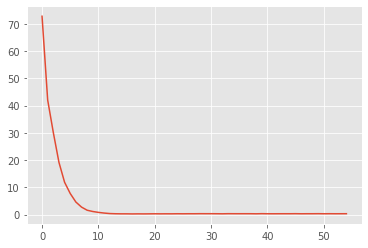

In [70]:
from matplotlib.pyplot import plot

my_clf = MySGDClassifier(batch_generator,  C = 1, alpha=0.0001, max_epoch =5, model_type='lin_reg', batch_size = 1000)
my_clf.fit(X_train, y_train)
my_clf.predict(X_train)

errors = my_clf.errors_log['loss']
plot(range(len(errors)), errors)

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

Разбиваем так, чтобы в трейн и тест не попали элементы, принадлежащие одной группе. Валидацию для параметров будем делать по лосу, потом подберем порог по f1-score также на валидации.

Для лин.регрессии

In [71]:
spliting = []

ind_0 = np.array(np.where(groups_train < 43))[0][:, np.newaxis] 
ind_1 = np.array(np.where((43 <= groups_train) & (groups_train < 86)))[0][:, np.newaxis] 
ind_2 = np.array(np.where((groups_train >= 86)))[0][:, np.newaxis] 

spliting.append([np.vstack((ind_0,ind_1)).ravel(), ind_2.ravel()])
spliting.append([np.vstack((ind_0,ind_2)).ravel(), ind_1.ravel()])
spliting.append([np.vstack((ind_1,ind_2)).ravel(), ind_0.ravel()])

In [72]:
def loss_lin(pred, y_true):
    return ((pred - y_true)**2).mean()

In [73]:
min_score = 100000

for alpha in np.arange(0.0001, 0.1, 0.01):
    print(alpha)
    for C in np.logspace(3, -3, 10):
        for max_epoch in range(5, 30, 5):
            scores = [] 
            for train, test in spliting:
                my_clf = MySGDClassifier(batch_generator, alpha=alpha, max_epoch=max_epoch, model_type='lin_reg', batch_size = 1000, C=C)
                my_clf.fit(X_train[train], y_train[train])
                pred = my_clf.predict(X_train[test])
                scores.append(loss_lin(pred, y_train[test]))
            if sum(scores)/3 < min_score: 
                min_score = sum(scores)/3
                alpha_best_lin, C_best_lin, max_epoch_best_lin = alpha, C, max_epoch

0.0001


/usr/lib64/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in square
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
/usr/lib64/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in add


0.0101


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in add
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in multiply


0.0201


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in add


0.0301
0.040100000000000004


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in add


0.050100000000000006
0.0601
0.07010000000000001
0.0801
0.0901


Теперь для лог. регрессии

In [81]:
def loss_log(pred, y_true):
    return -(y_true * np.log(pred) + (1- y_true)*np.log(1-pred)).mean()


In [82]:
min_score = 100000

for alpha in np.arange(0.0001, 0.01, 0.001):
    print(alpha)
    for C in np.logspace(3, -3, 10):
        for max_epoch in range(5, 30, 5):
            scores = [] 
            for train, test in spliting:
                my_clf = MySGDClassifier(batch_generator, alpha=alpha, max_epoch=max_epoch, C=C, model_type='log_reg', batch_size = 1000)
                my_clf.fit(X_train[train], y_train[train])
                pred = my_clf.predict(X_train[test])
                scores.append(loss_log(pred, y_train[test]))
            if sum(scores)/3 < min_score: 
                min_score = sum(scores)/3
                alpha_best_log, C_best_log, max_epoch_best_log = alpha, C, max_epoch

0.0001


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in add


0.0011


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in multiply


0.0021
0.0031
0.0041
0.0051
0.0061
0.0071
0.0081
0.0091


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

Подберем сначала порог для лин регрессии:

In [80]:
from sklearn.metrics import f1_score
max_score = 0
for tresh in np.arange(-0.5, 0.5, 0.05):
    scores = []
    for train, test in spliting:
                my_clf = MySGDClassifier(batch_generator, alpha=alpha_best_lin, max_epoch=max_epoch_best_lin, model_type='lin_reg', C = C_best_lin, batch_size = 1000)
                my_clf.fit(X_train[train], y_train[train])
                pred = my_clf.predict(X_train[test])
                new_pred = np.where(pred < tresh, 0, 1)
                scores.append(f1_score(new_pred,y_train[test]))
    if sum(scores)/3 > max_score: 
        max_score = sum(scores)/3
        tresh_best_lin = tresh
                

In [77]:
max_score, tresh_best_lin

(0.6088806320604666, 0.1499999999999999)

Теперь порог для лог регрессии:

In [84]:
from sklearn.metrics import f1_score
max_score = 0
for tresh in np.arange(0.4, 0.6, 0.005):
    scores = []
    for train, test in spliting:
                my_clf = MySGDClassifier(batch_generator, alpha=alpha_best_log, max_epoch=max_epoch_best_log, model_type='log_reg', batch_size = 1000, C = C_best_log)
                my_clf.fit(X_train[train], y_train[train])
                pred = my_clf.predict(X_train[test])                
                new_pred = np.where(pred < tresh, 0, 1)
                scores.append(f1_score(new_pred,y_train[test]))
    if sum(scores)/3 > max_score: 
        max_score = sum(scores)/3
        tresh_best_log = tresh
                

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


In [85]:
max_score, tresh_best_log

(0.6189132502045861, 0.5300000000000001)

Скор лучше у лог. регрессии

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [86]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    pair_id =  new_doc['pair_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title, pair_id))

In [87]:
import numpy as np
X_test = []
pair_ids = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title, pair_id) in enumerate(docs):
        pair_ids.append(pair_id)
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, pair_id_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
pair_ids = np.array(pair_ids)
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape, pair_ids.shape)

(16627, 15) (16627,) (16627,)


In [88]:
X_test = scaler.transform(X_test)

In [92]:
my_clf = MySGDClassifier(batch_generator, alpha=alpha_best_log, max_epoch=max_epoch_best_log,  C=C_best_log, model_type='log_reg', batch_size=1000)
my_clf.fit(X_train, y_train)
pred = my_clf.predict(X_test)
new_pred = np.where(pred < tresh_best_log, 0, 1)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


In [93]:
df = pd.DataFrame({'pair_id': pair_ids, 'target': new_pred})

In [94]:
df.to_csv('sub_log.csv', index=False)

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***